In [1]:
from uninaannpy import neural_network as nn
from uninaannpy import error_functions as ef
from uninaannpy import activation_functions as af
from uninaannpy import datasets as ds
from uninaannpy import utility as ut

import numpy as np
import pandas as pd
import os

#Costruzione path del dataset
current_path = os.getcwd()
data_path = os.path.join(current_path, 'data')
train_file_path = os.path.join(data_path, "mnist_train.csv")
test_file_path = os.path.join(data_path, "mnist_test.csv")

#Lettura csv con pandas
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

#Ottenimento array per il training e il testing
train_array = np.array(train_data)
test_array = np.array(test_data)

#Estrapoliamo il numero di righe e di colonne di train e test
train_rows, train_cols = train_array.shape 
test_rows, test_cols = test_array.shape  

#Mescola casualmente i dati prima di suddividerli in set di sviluppo e training
np.random.shuffle(train_array)  
#Calcolo percentuale dati per il validation set
validation_percentage = 0.20
val_index = int(np.ceil(train_rows * validation_percentage))

#Distribuzione training, validation e test set
train_in, train_labels = ds.get_mnist_training(train_array, train_rows, train_cols, val_index)
validation_in, validation_labels = ds.get_mnist_validation(train_array, train_cols, val_index)
test_in, test_labels = ds.get_mnist_testing(test_array, test_cols, test_rows)

#Creazione rete neurale
#Assegnazione funzioni di attivazione per ogni strato della rete
hidden_activation_functions = [af.tanh]

#Assegnazione numero di neuroni per ogni strato
hidden_layers = [200]
#Assegnazione della funzione di attivazione e di errore per l'ultimo strato della rete
output_activation_function = af.identity
error_function = ef.cross_entropy_softmax

#Estrazione input e target
input_layer_size = train_in.shape[0]
output_layer_size = train_labels.shape[0]
net = nn.NeuralNetwork(hidden_activation_functions, output_activation_function, error_function,
                input_layer_size, hidden_layers, output_layer_size)

#Copia la rete principale in una per il training
training_net = net.duplicate_network()
training_net.get_net_structure()

Numero di strati nascosti: 1
Dimensione dell'input: 784
Dimensione dell'output: 10
Neuroni negli strati nascosti: 200
Funzioni di attivazione: tanh, identity
Funzione di errore: cross_entropy_softmax


In [2]:
from uninaannpy.learning_functions import RPropType

#batch training
train_err, validation_err, train_accuracy, validation_accuracy = training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=40, learning_rate=0.00001, rprop_type=RPropType.STANDARD)


0/40
Training Accuracy: 9.31478%,
Validation Accuracy: 9.09242%

1/40
Training Accuracy: 29.01519%,
Validation Accuracy: 29.18577%

2/40
Training Accuracy: 55.46574%,
Validation Accuracy: 54.72956%

3/40
Training Accuracy: 33.7132%,
Validation Accuracy: 33.53613%

4/40
Training Accuracy: 37.11536%,
Validation Accuracy: 36.7864%

5/40
Training Accuracy: 39.38415%,
Validation Accuracy: 38.82824%

6/40
Training Accuracy: 56.90535%,
Validation Accuracy: 56.97975%

7/40
Training Accuracy: 70.24105%,
Validation Accuracy: 69.78915%

8/40
Training Accuracy: 71.47649%,
Validation Accuracy: 70.64755%

9/40
Training Accuracy: 78.08079%,
Validation Accuracy: 77.51479%

10/40
Training Accuracy: 81.31419%,
Validation Accuracy: 80.94841%

11/40
Training Accuracy: 82.36213%,
Validation Accuracy: 81.9485%

12/40
Training Accuracy: 86.54347%,
Validation Accuracy: 86.14051%

13/40
Training Accuracy: 87.10806%,
Validation Accuracy: 86.56555%

14/40
Training Accuracy: 88.46226%,
Validation Accuracy: 87.52

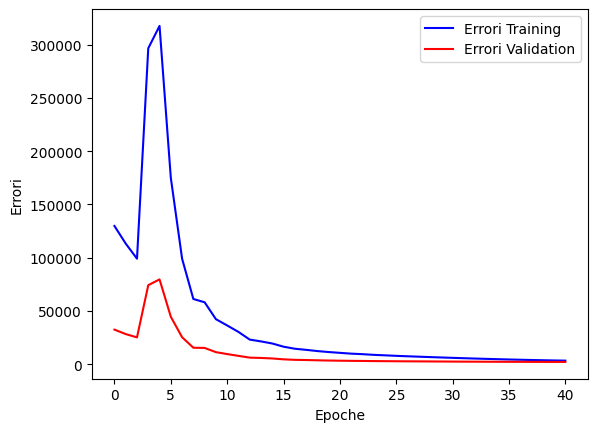

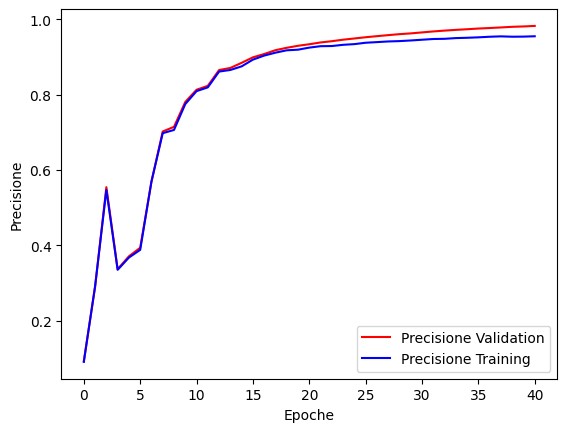

In [6]:
from matplotlib import pyplot as plt

#Stampa grafico dell'errore ottenuto attraverso il training
plt.figure()
plt.plot(train_err, 'b', label='Errori Training')
plt.plot(validation_err, 'r', label='Errori Validation')
plt.xlabel('Epoche')
plt.ylabel('Errori')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracy, 'r', label='Precisione Validation')
plt.plot(validation_accuracy, 'b', label='Precisione Training')
plt.xlabel('Epoche')
plt.ylabel('Precisione')
plt.legend()
plt.show()

In [10]:
#Stampa accuracy per training e test set
accuracy_test = training_net.network_accuracy(test_in, test_labels)
print(f'Test accuracy: {accuracy_test}%')
accuracy_training = training_net.network_accuracy(train_in, train_labels)
print(f'Train accuracy: {accuracy_training}%')

Test accuracy: 95.5414%
Train accuracy: 98.25413%


Probabilità predette dalla rete non addestrata:
Classe 0: 1.71385%
Classe 1: 7.76793%
Classe 2: 2.53803%
Classe 3: 52.45683%
Classe 4: 1.28199%
Classe 5: 1.23677%
Classe 6: 19.97739%
Classe 7: 2.11408%
Classe 8: 2.36564%
Classe 9: 8.54749%

Probabilità predette dalla rete addestrata:
Classe 0: 0.00023%
Classe 1: 0.00285%
Classe 2: 0.00061%
Classe 3: 0.11743%
Classe 4: 0.00123%
Classe 5: 0.00791%
Classe 6: 4e-05%
Classe 7: 3e-05%
Classe 8: 99.86182%
Classe 9: 0.00786%


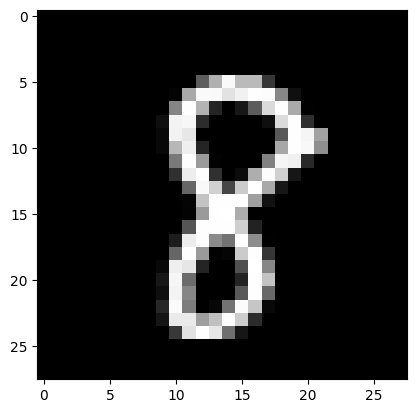

In [14]:
#Predizione rete senza addestramento e rete addestrata
image = 47998
ut.test_prediction(net, training_net, image, train_in)